**Introduction**

In semi-supervised domain adaptation (SSDA), prototypes can play a crucial role in aligning features across domains. A prototype is essentially a representative feature vector for each class, often computed as the mean of feature embeddings for samples belonging to that class. Here's how prototypes are used in SSDA:

When to use prototypes?

**Domain Adaptation:**

Prototypes align features between source and target domains at the class level.

They reduce domain shift by ensuring features cluster around their respective prototypes.

**Semi-Supervised Learning:**

Prototypes assist in generating pseudo-labels for unlabeled data by assigning them to the nearest prototype.

They improve feature alignment and classification accuracy.

**Our approach?**

This approach is not fully a Prototypical Network, because it goes beyond few-shot learning and integrates domain adaptation with semi-supervised techniques. Instead, it's a hybrid that combines prototype-based learning with domain adaptation and pseudo-labeling

**Imports**

In [147]:
import os
import kagglehub
import random
from PIL import Image

import json

from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, models

import matplotlib.pyplot as plt


In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Data Processing

In [149]:
# Download latest version
path = kagglehub.dataset_download("ambityga/imagenet100")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagenet100


In [150]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [151]:
# walk_through_dir(path)

In [152]:
train_pathx1 = os.path.join(path, "train.X1")
train_pathx1

'/kaggle/input/imagenet100/train.X1'

Class Directories: ['n01531178', 'n01440764', 'n01494475', 'n01950731', 'n01795545', 'n01632777', 'n02012849', 'n01775062', 'n02007558', 'n01484850', 'n01930112', 'n01984695', 'n02037110', 'n02018795', 'n01695060', 'n01978455', 'n01749939', 'n01824575', 'n01914609', 'n01833805', 'n01924916', 'n01665541', 'n01820546', 'n01687978', 'n01818515']
Random Class Directory: n02018795
Random Image Selected: n02018795_16573.JPEG from Class: n02018795
Image Path: /kaggle/input/imagenet100/train.X1/n02018795/n02018795_16573.JPEG
Image Exists


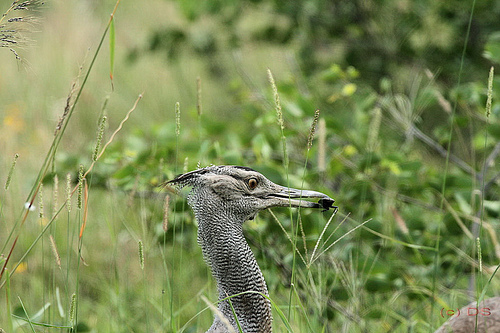

In [153]:
# List all class directories
class_dirs = [d for d in os.listdir(train_pathx1) if os.path.isdir(os.path.join(train_pathx1, d))]
random_class_dir = random.choice(class_dirs)

print('Class Directories:', class_dirs)
print('Random Class Directory:', random_class_dir)

# Path to selected class directory
class_path = os.path.join(train_pathx1, random_class_dir)

# List all images
images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg', 'JPEG'))]

if not images:
    print(f"No images found in class directory: {random_class_dir}")
else:
    # Select a random image
    random_image = random.choice(images)
    print(f"Random Image Selected: {random_image} from Class: {random_class_dir}")

    # Open and display the image
    image_path = os.path.join(class_path, random_image)
    print("Image Path:", image_path)
    if os.path.exists(image_path):
        print("Image Exists")
        img = Image.open(image_path).convert('RGB')
        # img.load()
        # img.show()
        display(img)
    else:
        print(f"Selected image does not exist: {random_image}")


In [154]:
json_path = '/kaggle/input/imagenet100/Labels.json'

with open(json_path, 'r') as json_file:
    labels_data = json.load(json_file)

print('labels_data',labels_data)


labels_data {'n01968897': 'chambered nautilus, pearly nautilus, nautilus', 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio', 'n01818515': 'macaw', 'n02011460': 'bittern', 'n01496331': 'electric ray, crampfish, numbfish, torpedo', 'n01847000': 'drake', 'n01687978': 'agama', 'n01740131': 'night snake, Hypsiglena torquata', 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'n01491361': 'tiger shark, Galeocerdo cuvieri', 'n02007558': 'flamingo', 'n01735189': 'garter snake, grass snake', 'n01630670': 'common newt, Triturus vulgaris', 'n01440764': 'tench, Tinca tinca', 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'n02002556': 'white stork, Ciconia ciconia', 'n01667778': 'terrapin', 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'n01924916': 'flatworm, platyhelminth', 'n01751748': 'sea snake', 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'n01729977': 'gr

**Datasets/ DataLoader**

In [155]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [156]:
#split the dataset to create an artifical domain from the source domain with augmentation
train_dataset = ImageFolder(root=train_pathx1, transform=simple_transform)


In [157]:
source_dataset_size = len(train_dataset) / 2
target_dataset_size = len(train_dataset) - (source_dataset_size)

print(f"Source Dataset Size: {source_dataset_size}")
print(f"Target Dataset Size: {target_dataset_size}")

# Split the dataset into source and target
source_subset, target_subset = random_split(train_dataset, [int(source_dataset_size), int(target_dataset_size)])

target_labeled_size = len(target_subset) / 10
target_unlabeled_size = len(target_subset) - target_labeled_size

print(f"Target Labeled Size: {target_labeled_size}")
print(f"Target Unlabeled Size: {target_unlabeled_size}")

target_labeled_subset, target_unlabeled_subset = random_split(target_subset, [int(target_labeled_size), int(target_unlabeled_size)])

Source Dataset Size: 16250.0
Target Dataset Size: 16250.0
Target Labeled Size: 1625.0
Target Unlabeled Size: 14625.0


In [158]:
#add noise to target domain
# Custom noise injection function
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are within [0, 1]

# Define transform with noise injection
target_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: add_gaussian_noise(img, mean=0, std=0.1))  # Inject noise
])

# Apply transformations to target dataset
target_subset.dataset.transform = target_transforms

In [159]:
#dataloader
batch_size = 32

source_loader = DataLoader(source_subset, batch_size=batch_size, shuffle=True, drop_last=True)
target_labeled_loader = DataLoader(target_labeled_subset, batch_size=batch_size, shuffle=True, drop_last=True)
target_unlabeled_loader = DataLoader(target_unlabeled_subset, batch_size=batch_size, shuffle=True, drop_last=True)

In [160]:
len(source_loader), len(target_labeled_loader), len(target_unlabeled_loader)

(507, 50, 457)

In [161]:
images, labels = next(iter(source_loader))

print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Images Shape: torch.Size([32, 3, 224, 224])
Labels Shape: torch.Size([32])


In [162]:
target_images, labels = next(iter(target_labeled_loader))

print("Target Images Shape:", images.shape)
print("Target Labels Shape:", labels.shape)

Target Images Shape: torch.Size([32, 3, 224, 224])
Target Labels Shape: torch.Size([32])


In [163]:
target_images, _ = next(iter(target_unlabeled_loader))

print("Target Images Shape:", images.shape)

Target Images Shape: torch.Size([32, 3, 224, 224])


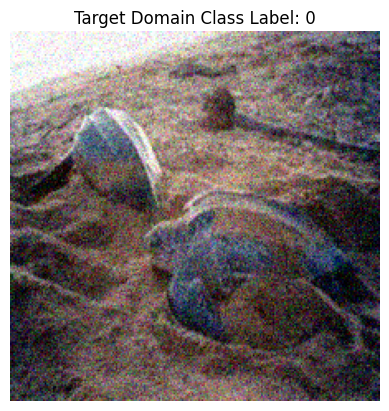

In [164]:
# Display the first image
plt.imshow(images[0].permute(1, 2, 0))  # Permute to match image dimensions (H x W x C)
plt.title(f"Target Domain Class Label: {labels[0].item()}")
plt.axis("off")
plt.show()

Compute Class Prototypes

In [165]:
def compute_prototypes(embeddings, labels, num_classes):
    prototypes = []
    for cls in range(num_classes):
        cls_embeddings = embeddings[labels == cls]
        if cls_embeddings.shape[0] == 0:  # Handle empty classes
            prototype = torch.zeros_like(embeddings[0])  # Use zero vector instead
        else:
            prototype = torch.mean(cls_embeddings, dim=0)
        prototypes.append(prototype)
    return torch.stack(prototypes)



def euclidean_distance(x, y):
      # Normalize feature embeddings to prevent large distance values
    x = torch.nn.functional.normalize(x, dim=-1)
    y = torch.nn.functional.normalize(y, dim=-1)
    return torch.norm(x - y, dim=-1)

Models

In [166]:
# Load ResNet-50 pre-trained model
feature_extractor = models.resnet50(pretrained=True)

# Modify the fully connected layer for your task
num_classes = 25  # Replace with the number of classes in your dataset

for param in feature_extractor.parameters():
    param.requires_grad = False


feature_extractor.fc = nn.Identity()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [167]:
#classifier

classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)


# nn.init.xavier_uniform_(classifier.weight)
# nn.init.zeros_(classifier.bias)


Training loop

workflow where you're computing prototypes for each class, calculating distances between embeddings and their corresponding prototypes, and then using a loss function (criterion) to measure how well these distances align with a target (in this case, zeros).

In [176]:
# Define loss functions
criterion = nn.CrossEntropyLoss()  # Supervised classification loss
consistency_criterion = nn.MSELoss()  # Consistency loss for unlabeled data

# Define optimizer
optimizer = optim.SGD(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=0.001, momentum=0.9)



feature_extractor = feature_extractor.to(device)
classifier = classifier.to(device)

num_epochs = 10
threshold = 0.70  # pseudo-label

for epoch in range(num_epochs):
    feature_extractor.train()
    classifier.train()

    all_embeddings = []
    all_labels = []

    # Initialize running losses and batch counters for each loop
    running_loss_source = 0.0
    running_loss_target_labeled = 0.0
    running_loss_target_unlabeled = 0.0
    source_batches = 0
    target_labeled_batches = 0
    target_unlabeled_batches = 0

    # Supervised learning on the source domain
    for images, labels in source_loader:
        images, labels = images.to(device), labels.to(device)

        # Extract features and compute logits
        embeddings = feature_extractor(images).view(images.size(0), -1)
        logits = classifier(embeddings)
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1)

        # Append embeddings and labels for prototypes
        all_embeddings.append(embeddings)
        all_labels.append(labels)

        # Compute prototypes and distances
        prototypes = compute_prototypes(torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0), num_classes)
        prototypes = torch.nn.functional.normalize(prototypes, dim=-1)
        distances = torch.stack([euclidean_distance(embeddings, prototype) for prototype in prototypes], dim=1)
        distances = torch.clamp(distances, min=0, max=5)

        # Compute classification loss
        classification_loss = criterion(logits, labels) + criterion(distances, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        classification_loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss_source += classification_loss.item()
        source_batches += 1

    # Supervised learning on the labeled target domain

    for images, labels in target_labeled_loader:
        images, labels = images.to(device), labels.to(device)

        # Extract features and compute logits
        embeddings = feature_extractor(images).view(images.size(0), -1)
        logits = classifier(embeddings)
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1)

        # Append embeddings and labels for prototypes
        all_embeddings.append(embeddings)
        all_labels.append(labels)

        # Compute prototypes and distances
        prototypes = compute_prototypes(torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0), num_classes)
        prototypes = torch.nn.functional.normalize(prototypes, dim=-1)
        distances = torch.stack([euclidean_distance(embeddings, prototype) for prototype in prototypes], dim=1)
        distances = torch.clamp(distances, min=0, max=5)

        # Compute classification loss
        classification_loss = criterion(logits, labels) + criterion(distances, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        classification_loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss_target_labeled += classification_loss.item()
        target_labeled_batches += 1

    # Unsupervised learning on the unlabeled target domain
    for images, _ in target_unlabeled_loader:
        images = images.to(device)

        # Extract embeddings
        embeddings = feature_extractor(images).view(images.size(0), -1)

        # Compute distances and pseudo-labels
        prototypes = compute_prototypes(torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0), num_classes)
        distances = torch.stack([euclidean_distance(embeddings, prototype) for prototype in prototypes], dim=1)
        pseudo_labels = distances.argmin(dim=1).long()

        # Filter high-confidence samples
        confidence = distances.min(dim=1).values
        high_confidence_mask = confidence < threshold
        high_confidence_embeddings = embeddings[high_confidence_mask]
        high_confidence_pseudo_labels = pseudo_labels[high_confidence_mask]

        # Update prototypes with high-confidence embeddings
        updated_prototypes = compute_prototypes(
            torch.cat([torch.cat(all_embeddings, dim=0), high_confidence_embeddings], dim=0),
            torch.cat([torch.cat(all_labels, dim=0), high_confidence_pseudo_labels], dim=0),
            num_classes
        )

        # Compute consistency loss
        logits = classifier(embeddings)
        loss1 = criterion(logits, pseudo_labels)
        loss2 = criterion(distances, pseudo_labels)
        consistency_loss = loss1 + loss2

        # Backward pass and optimizer step
        optimizer.zero_grad()
        consistency_loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss_target_unlabeled += consistency_loss.item()
        target_unlabeled_batches += 1

    # Compute average losses
    avg_loss_source = running_loss_source / source_batches
    avg_loss_target_labeled = running_loss_target_labeled / target_labeled_batches
    avg_loss_target_unlabeled = running_loss_target_unlabeled / target_unlabeled_batches
    total_loss = avg_loss_source + avg_loss_target_labeled + avg_loss_target_unlabeled

    print(f"Epoch {epoch+1}/{num_epochs}, Source Loss: {avg_loss_source:.4f}, "
          f"Target Labeled Loss: {avg_loss_target_labeled:.4f}, "
          f"Target Unlabeled Loss: {avg_loss_target_unlabeled:.4f}, Total Loss: {total_loss:.4f}")



Epoch 1/10, Source Loss: 3.5728, Target Labeled Loss: 3.5793, Target Unlabeled Loss: 3.6018, Total Loss: 10.7538
Epoch 2/10, Source Loss: 3.5743, Target Labeled Loss: 3.5719, Target Unlabeled Loss: 3.5978, Total Loss: 10.7440
Epoch 3/10, Source Loss: 3.5714, Target Labeled Loss: 3.5784, Target Unlabeled Loss: 3.5938, Total Loss: 10.7436
Epoch 4/10, Source Loss: 3.5719, Target Labeled Loss: 3.5587, Target Unlabeled Loss: 3.5926, Total Loss: 10.7232
Epoch 5/10, Source Loss: 3.5673, Target Labeled Loss: 3.5499, Target Unlabeled Loss: 3.5860, Total Loss: 10.7031
Epoch 6/10, Source Loss: 3.5599, Target Labeled Loss: 3.5534, Target Unlabeled Loss: 3.5815, Total Loss: 10.6948
Epoch 7/10, Source Loss: 3.5603, Target Labeled Loss: 3.5583, Target Unlabeled Loss: 3.5917, Total Loss: 10.7103
Epoch 8/10, Source Loss: 3.5635, Target Labeled Loss: 3.5471, Target Unlabeled Loss: 3.5942, Total Loss: 10.7048
Epoch 9/10, Source Loss: 3.5521, Target Labeled Loss: 3.5388, Target Unlabeled Loss: 3.5911, Tot

**Consistent Loss Across Domains**

Your source loss remains stable, suggesting that your model has learned its labeled source domain well.

Target labeled loss is slightly decreasing, which is good—it means your model is learning to align the labeled target domain with the source.

Target unlabeled loss is also trending downward, but very slowly, meaning pseudo-labeling and prototype refinement are progressing but could be improved.

**Total Loss Stabilization**

The total loss remains around 10.70 after several epochs, showing that adaptation is happening but at a gradual rate.

Since unsupervised loss (pseudo-labeling) is involved, adaptation might take longer than pure supervised learning.